In [1]:
# Load library

import sys
import argparse
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

sys.path.append('/home/hoheon/packages/')
from utils.keras import get_model_memory_usage
from utils.numpy import to_onehot

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Given data
train, test = tf.keras.datasets.cifar10.load_data()
x_train, y_train = train[0], train[1]
x_test, y_test = test[0], test[1]
y_train = to_onehot(y_train, 10).reshape(-1, 10)
y_test = to_onehot(y_test, 10).reshape(-1, 10)

np.save('./data/x_test', x_test[0:1])

#### Optimizer

In [3]:
bandwidth = 300
direction = 'single'

In [5]:
from runtime import GraphPartitioner
from runtime import read_txt

from utils.serialization import load_pickle

# Load data
server_runtime = pd.read_csv('./result/server_runtime.csv')
client_runtime = pd.read_csv('./result/device_runtime.csv')
d_size = pd.read_csv('./result/data_size.csv')
layer_names = load_pickle('./result/layer_seq.pickle')
client_lib_runtimes = read_txt('./result/runtimes_client.txt')
server_lib_runtimes = read_txt('./result/runtimes_server.txt')

# Prep
layer_mapping = {'input_1':'input', 'dense_1':'dense', 'flatten_1':'flatten', 'input_2':'input'}
layer_names = [layer_mapping[element] if element in layer_mapping.keys() else element for element in layer_names]
server_runtime = server_runtime.replace(layer_mapping)
client_runtime = client_runtime.replace(layer_mapping)
avg_client_runtime = client_runtime.groupby('layer_name').mean().reindex(layer_names)
avg_server_runtime = server_runtime.groupby('layer_name').mean().reindex(layer_names)

In [6]:
gp = GraphPartitioner(avg_server_runtime, server_lib_runtimes, avg_client_runtime, client_lib_runtimes, d_size)
exitpoint = gp.get_exitpoint(bandwidth, direction=direction)

<AxesSubplot:xlabel='a', ylabel='runtime'>

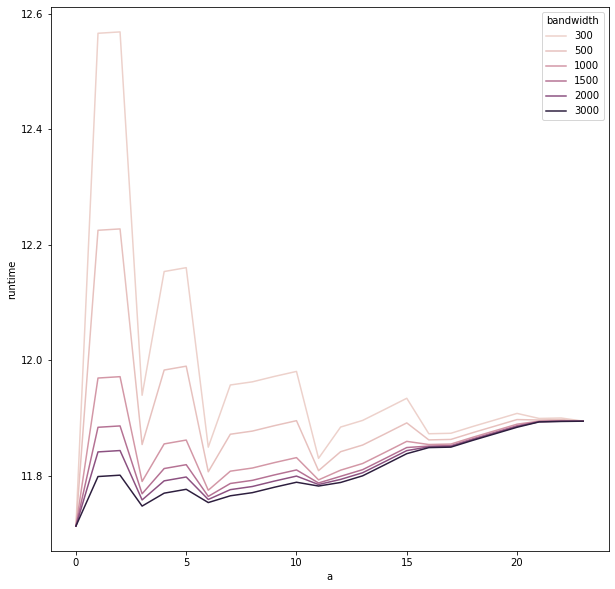

In [9]:
bandwidths = [300, 500, 1000, 1500, 2000, 3000]

runtimes_single = dict()

for bandwidth in bandwidths:
    _ = gp.search_exitpoint_single(bandwidth, batch_size=1)
    runtimes_single[bandwidth] = _ 
    
df = pd.DataFrame(runtimes_single.values()).T
df.columns = bandwidths

df = pd.DataFrame(df.stack()).reset_index(drop=False)
df.columns = ['a', 'bandwidth', 'runtime']


fig, axes = plt.subplots(figsize=(10, 10))
sns.lineplot(x='a', y='runtime', data=df, hue='bandwidth')

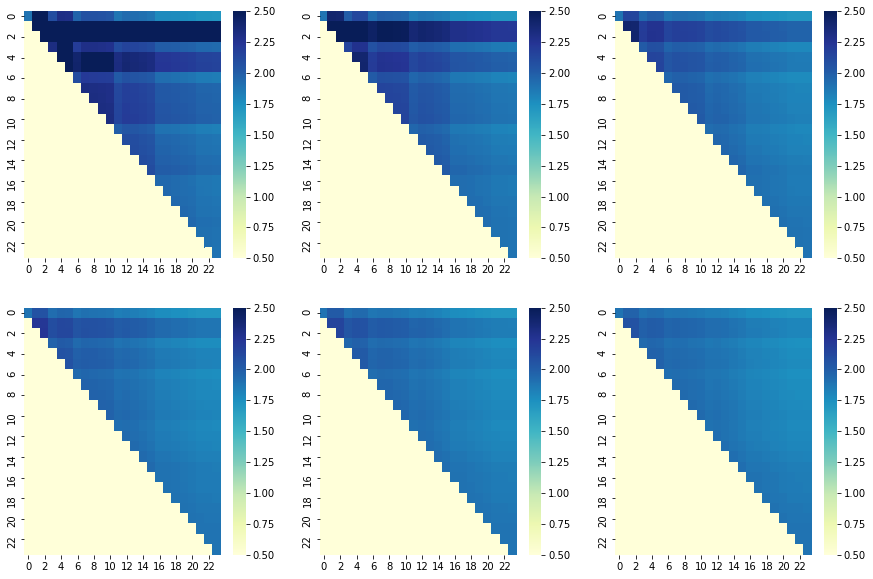

In [8]:
runtimes_bidrection = dict()

for bandwidth in bandwidths:
    _ = gp.search_exitpoint_bidirection(bandwidth, batch_size=1)
    runtimes_bidrection[bandwidth] = _
    
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    if i < 3:
        sns.heatmap(runtimes_bidrection[bandwidths[i]] -10, ax=axes[0, i],  vmin=0.5, vmax=2.5, cmap='YlGnBu')
    else:
        sns.heatmap(runtimes_bidrection[bandwidths[i]] -10, ax=axes[1, i-3], vmin=0.5, vmax=2.5, cmap='YlGnBu')

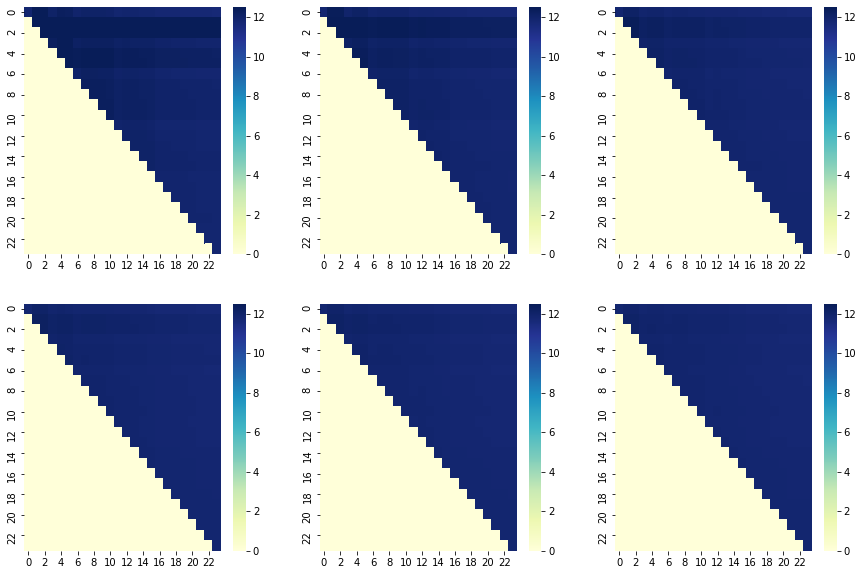

In [10]:
runtimes_bidrection = dict()

for bandwidth in bandwidths:
    _ = gp.search_exitpoint_bidirection(bandwidth, batch_size=1)
    runtimes_bidrection[bandwidth] = _
    
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    if i < 3:
        sns.heatmap(runtimes_bidrection[bandwidths[i]], ax=axes[0, i],  vmin=0., vmax=12.5, cmap='YlGnBu')
    else:
        sns.heatmap(runtimes_bidrection[bandwidths[i]], ax=axes[1, i-3], vmin=0., vmax=12.5, cmap='YlGnBu')

#### Execute in client

In [89]:
# Build model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow import device

# Given data
x_test = np.load('./data/x_test.npy')


# Build model
sub_model = VGG19(include_top=False, input_shape=(32, 32, 3), classes=10)
flat = Flatten()(sub_model.layers[-1].output)
classify_ = Dense(10, activation='softmax')(flat)
model = Model(inputs=sub_model.inputs, outputs=classify_)
model.load_weights('./cache/best_param.hdf5')

model = Model(model.layers[0].input, model.layers[exitpoint].output)

In [90]:
model = tf.keras.models.Model(model.layers[0].input, model.layers[exitpoint].output)
model.summary()

def main():
    result = model(x_train[1:2])
    np.save('/home/hoheon/Jupyter/2021/EdgeCom/data/mid_data', result.numpy())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)        

In [91]:
with device('CPU:0'):
    main()

##### Figure 5. Partition point

<AxesSubplot:>

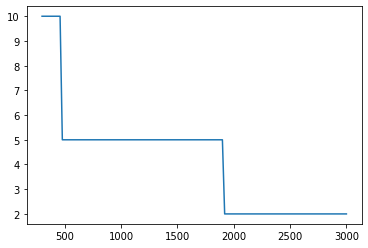

In [74]:
bandwidths = list(range(100, 3001, 20))

cut_points_bi = dict()
cut_points_bi = dict()

for b in bandwidths:
    cp = gp.get_exitpoint(b, direction='bidirection')
    cut_points[b] = cp

inbound = [i[0] for i in cut_points.values()]
sns.lineplot(x=bandwidths, y=inbound)

##### Reuslt

In [19]:
import sys
sys.path.append('/home/hoheon/packages/')

with open('./result/runtimes_total.txt') as f:
    total_runtime = f.readlines()
total_runtime = ''.join(total_runtime).split('\n')
total_runtime = [float(_) for _ in total_runtime if _ != '']

/usr/local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

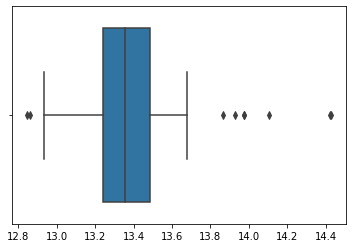

In [25]:
sns.boxplot(total_runtime)

In [ ]:
origin = np.load('./data/x_test.npy')
edge_data = np.load('./data/mid_data.npy')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(origin.reshape(32, 32, 3))
axes[1].imshow(edge_data.reshape(8 , 8, 256).mean(axis=2).reshape(8, 8, 1))

##### Keras: AlexNet memory size

In [85]:
# (3) Create a sequential model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11),\
 strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Pooling 
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(17))
model.add(Activation('softmax'))

model.summary()

# (4) Compile 
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_18 (Activation)   (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_19 (Activation)   (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 256)        

In [88]:
get_model_memory_usage(1, model)

110.919